In [1]:
import torch
from torch import nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [27]:
def plot_img(x):
    plt.figure()
    combined_image = np.concatenate((x[0][0].detach().numpy(), x[0][10].detach().numpy(), x[0][-1].detach().numpy()), axis=1)
    plt.imshow(combined_image)

    return

def crop_image(source_tensor, target_tensor):
    source_tensor_size = source_tensor.size()[2]
    target_tensor_size = target_tensor.size()[2]

    start_x = (source_tensor.size()[2] - target_tensor.size()[2]) // 2
    start_y = (source_tensor.size()[3] - target_tensor.size()[3]) // 2
    # print("source tensor")
    # print(source_tensor.shape)
    # print("target_tensor")
    # print(target_tensor.shape)
    # print("cropped_tensor")
    # print(source_tensor[:, :, start_x:start_x + target_tensor.size()[2], start_y:start_y + target_tensor.size()[3]].shape)

    return source_tensor[:, :, start_x:start_x + target_tensor.size()[2], start_y:start_y + target_tensor.size()[3]]

In [32]:
def double_conv(in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channel, out_channel, kernel_size=3),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.down_conv1 = double_conv(3, 64)
        self.down_conv2 = double_conv(64, 128)
        self.down_conv3 = double_conv(128, 256)
        self.down_conv4 = double_conv(256, 512)
        self.down_conv5 = double_conv(512, 1024)

        # self.up_conv1 = double_conv(1024, 512)
        # self.up_conv2 = double_conv()

        self.tarnspose_conv_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=1)
        self.tarnspose_conv_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=1)
        self.tarnspose_conv_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=1)
        self.tarnspose_conv_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=1)
        self.up_conv1 = double_conv(1024, 512)
        self.up_conv2 = double_conv(512, 256)
        self.up_conv3 = double_conv(256, 128)
        self.up_conv4 = double_conv(128, 64)

    def forward(self, image):
         # ////////////// ENCODER //////////////
        x1 = self.down_conv1(image)
        m1 = self.max_pool(x1)
        plot_img(m1)
        x2 = self.down_conv2(m1)
        m2 = self.max_pool(x2)
        plot_img(m2)
        x3 = self.down_conv3(m2)
        m3 = self.max_pool(x3)
        plot_img(m3)
        x4 = self.down_conv4(m3)
        print(x4.shape)
        m4 = self.max_pool(x4)
        plot_img(m4)
        x5 = self.down_conv5(m4)
        plot_img(x5)

        # ////////////// DECODER //////////////
        x = self.tarnspose_conv_1(x5)
        print(x.shape)
        x = self.up_conv1(torch.cat([x, crop_image(x4, x)], 1))
        print(x.shape)
        x = self.tarnspose_conv_2(x)
        x = self.up_conv2(torch.cat([x, crop_image(x3, x)], 1))
        x = self.tarnspose_conv_3(x)
        x = self.up_conv3(torch.cat([x, crop_image(x2, x)], 1))
        x = self.tarnspose_conv_4(x)
        x = self.up_conv4(torch.cat([x, crop_image(x1, x)], 1))
        return x

<class 'PIL.PngImagePlugin.PngImageFile'>
5760000
torch.Size([1, 3, 1200, 1600])


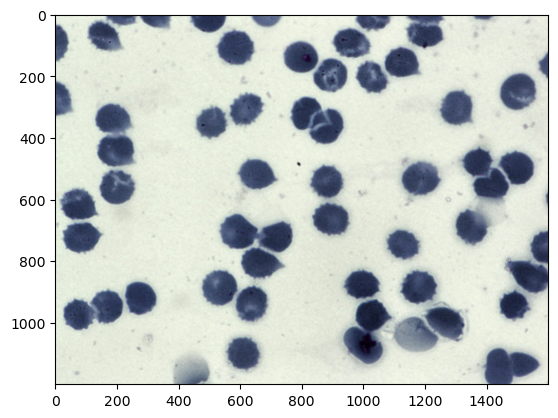

In [5]:
# image = torch.rand((1, 3, 572, 572))
image_path = "./test.png"
image = Image.open(image_path)
print(type(image))
image = np.array(image)
print(image.size)
image_tensor = torch.from_numpy(image)
plt.imshow(image_tensor)
image_tensor = image_tensor.float()
image_tensor = image_tensor.permute(2, 0, 1)
image_tensor = image_tensor.unsqueeze(0)
print(image_tensor.size())


torch.Size([1, 512, 142, 192])
torch.Size([1, 512, 68, 93])
torch.Size([1, 512, 64, 89])


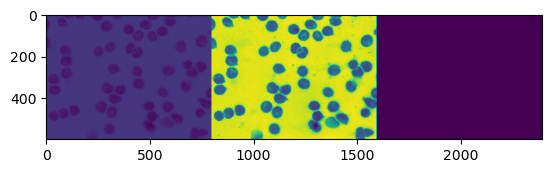

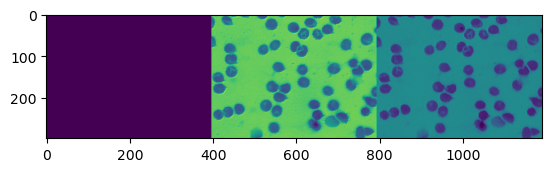

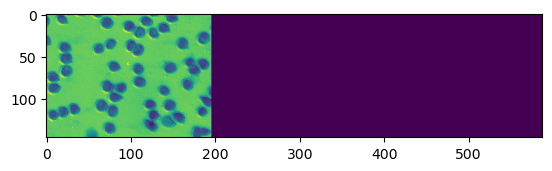

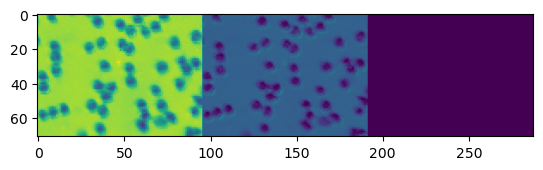

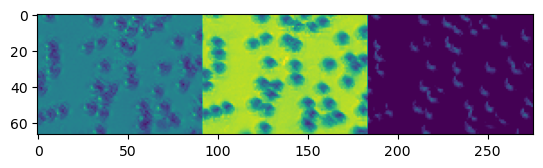

In [33]:
model = UNet()
output = model(image_tensor)


torch.Size([1, 1024, 67, 92])
tensor([[0.0197, 0.0291, 0.0359,  ..., 0.0297, 0.0296, 0.0295],
        [0.0207, 0.0277, 0.0350,  ..., 0.0293, 0.0297, 0.0299],
        [0.0259, 0.0268, 0.0287,  ..., 0.0296, 0.0300, 0.0293],
        ...,
        [0.0292, 0.0292, 0.0294,  ..., 0.0052, 0.0062, 0.0100],
        [0.0294, 0.0292, 0.0294,  ..., 0.0124, 0.0096, 0.0007],
        [0.0297, 0.0300, 0.0293,  ..., 0.0132, 0.0132, 0.0070]],
       grad_fn=<SelectBackward0>)


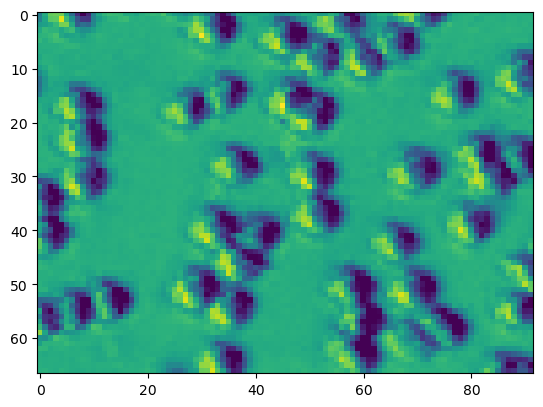

In [31]:
print(output.shape)
print(output[0][0])

plt.imshow(output[0][0].detach().numpy())